## Binary Decision Tree

In [1]:
import os
import pandas as pd
import numpy as np
from fastai.imports import *

df = pd.read_csv("titanicData/train.csv") #TRAIN
tst_df = pd.read_csv("titanicData/test.csv") #TEST

#get the modes of each feature
modes = df.mode().iloc[0]

In [3]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [5]:
cats=["Sex","Embarked"] #CATEGORICAL vars
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"] #CONTINUOUS vars
dep="Survived"  #dependent 

In [12]:
df.Sex.head(), df.Sex.cat.codes.head()

(0      male
 1    female
 2    female
 3    female
 4      male
 Name: Sex, dtype: category
 Categories (2, object): ['female', 'male'],
 0    1
 1    0
 2    0
 3    0
 4    1
 dtype: int8)

## Binary Split Based on Sex

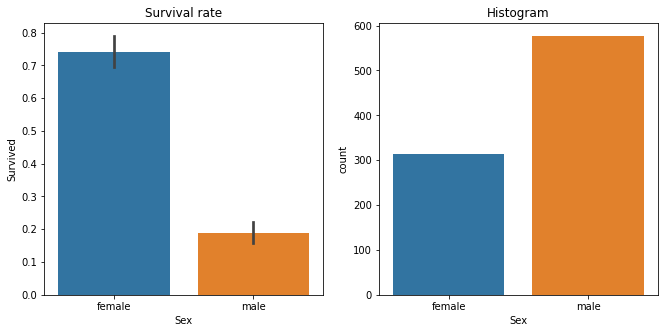

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

In [14]:
from numpy import random
from sklearn.model_selection import train_test_split


In [15]:
random.seed(442)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [16]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [17]:
preds = val_xs.Sex==0

In [18]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.242152466367713

## Binary Split based on Fare

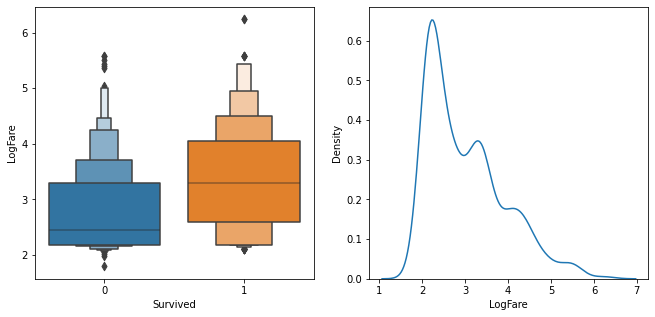

In [19]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

In [21]:
preds = val_xs.LogFare>2.7

In [22]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [23]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [24]:
score(trn_xs["Sex"], trn_y, 0.5)

0.4015830736709716

In [25]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [26]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,
        6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  , 14.  ,
       14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 , 21.  ,
       22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  , 28.  , 28.5 ,
       29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  , 34.  , 35.  ,
       36.  , 36.5 , 37.  , 38.  , 39.  , 40.  , 40.5 , 41.  , 42.  ,
       43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  ,
       51.  , 52.  , 54.  , 55.  , 55.5 , 56.  , 57.  , 58.  , 59.  ,
       60.  , 61.  , 62.  , 63.  , 64.  , 65.  , 66.  , 70.  , 70.5 ,
       71.  , 74.  , 80.  ])

In [27]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

5.0

In [28]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(5.0, 0.47801878055024793)

### Best variable to perform binary split 

In [29]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.4015830736709716),
 'Embarked': (0, 0.4771751626277058),
 'Age': (5.0, 0.47801878055024793),
 'SibSp': (0, 0.4796179915138978),
 'Parch': (0, 0.4783030514198359),
 'LogFare': (2.4390808375825834, 0.46019024267511216),
 'Pclass': (2, 0.46004922201541854)}

In [30]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [31]:
{o:min_col(males, o) for o in cols}


{'Embarked': (0, 0.38298022685828703),
 'Age': (4.0, 0.3739383515282915),
 'SibSp': (1, 0.3814337418477554),
 'Parch': (0, 0.38298022685828703),
 'LogFare': (2.4133032309283076, 0.3700844405461091),
 'Pclass': (1, 0.37232749130833215)}

In [32]:
{o:min_col(females, o) for o in cols}

{'Embarked': (0, 0.4188872401443252),
 'Age': (32.0, 0.4262953686532863),
 'SibSp': (2, 0.4200164009658997),
 'Parch': (3, 0.4272500157810102),
 'LogFare': (4.256321678298823, 0.37379283667358376),
 'Pclass': (2, 0.3431915029801608)}

In [33]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [34]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

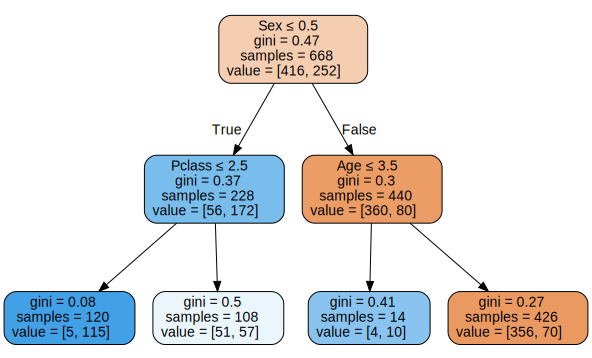

In [35]:
draw_tree(m, trn_xs, size=10)